# Boosted Decision Tree

### Looking at the csv files

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

import csv

with open('.//data//300.csv') as signalfile:
    readCSV = csv.reader(signalfile)
    variable = next(readCSV)

    row_numbers = []
    
    for thing in readCSV:
        row_number = thing[0]
        row_numbers.append(row_number)
        
    print("The number of data points is:", len(row_numbers))
    print("These are the variables:", variable[1:])

The number of data points is: 64754
These are the variables: ['weight', 'mBBres', 'METHT', 'mVHres', 'nTags', 'mLL', 'ptL1', 'ptL2', 'pTB1', 'pTB2', 'ptH', 'pTV', 'dEtaBB', 'dEtaLL', 'dPhiBB', 'dPhiLL', 'MV2c10B1', 'MV2c10B2', 'MCChannelNumber']


In [56]:
with open('.//data//background.csv') as bkgfile:
    readCSV = csv.reader(bkgfile)
    variable = next(readCSV)

    row_numbers = []
    
    for thing in readCSV:
        row_number = thing[0]
        row_numbers.append(row_number)
        
    print("The number of data points is:", len(row_numbers))
    print("These are the variables:", variable[1:])

The number of data points is: 622950
These are the variables: ['weight', 'mBBres', 'METHT', 'mVHres', 'nTags', 'mLL', 'ptL1', 'ptL2', 'pTB1', 'pTB2', 'ptH', 'pTV', 'dEtaBB', 'dEtaLL', 'dPhiBB', 'dPhiLL', 'MV2c10B1', 'MV2c10B2', 'MCChannelNumber']


### Now using pandas:

#### Opening the files using pandas
I also dropped variables we don't want to included

In [57]:
import pandas as pd

signal = pd.read_csv('.//data//300.csv', index_col=0)
background = pd.read_csv('.//data//background.csv', index_col=0)

signal.drop(["nTags", "MCChannelNumber", "mVHres"], axis=1, inplace=True)
background.drop(["nTags", "MCChannelNumber", "mVHres"], axis=1, inplace=True)

#### Setting up the train and test data
I also dropped the variable weight.
Here I used code from https://github.com/qiutt1994/AZhanalysis/blob/master/mlstudent3/training.py 

In [7]:
train_bkg, test_bkg = train_test_split(background, test_size=0.4, random_state=2)
train_signal, test_signal = train_test_split(signal, test_size=0.4, random_state=2)

train_y = len(train_bkg) * [0] + len(train_signal) * [1]
test_y = len(test_bkg) * [0] + len(test_signal) * [1]

train_x = pd.concat([train_bkg, train_signal], ignore_index=True)
test_x = pd.concat([test_bkg, test_signal], ignore_index=True)

train_x.drop(["weight"], axis=1, inplace=True)
test_x.drop(["weight"], axis=1, inplace=True)

print("Data has been split into test and train samples")
print("\tN(train) = ", len(train_x))
print("\tN(test)  = ", len(test_x))

Data has been split into test and train samples
	N(train) =  412622
	N(test)  =  275082


In [8]:
print("\033[1mFit the decision tree\033[0m")
BDT_clf = AdaBoostClassifier(n_estimators=100).fit(train_x, train_y)

print("... now compute the decision tree score")
train_score = BDT_clf.score(train_x, train_y)
test_score  = BDT_clf.score(test_x, test_y)

print("\nDecision Tree Classifier Score is:")
print("\tTrain Score = ", train_score, " (This measure of performance is biased)")
print("\tTest Score  = {:5.4f}".format(test_score))
print("\tNumber of mis-classified test data = {:2.1f}".format((1-test_score)*len(test_x)))

Fit the decision tree
... now compute the decision tree score

Decision Tree Classifier Score is:
	Train Score =  0.9059502401713917  (This measure of performance is biased)
	Test Score  = 0.9060
	Number of mis-classified test data = 25866.0


## Evaluating the model


Study the test data

confusion matrix (test) = 
 [[249072    108]
 [ 25758    144]]


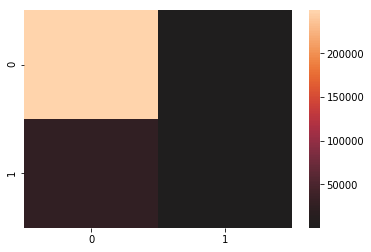


Check ground truth against predictions for the test sample
Truth	Prediction	Correct Prediction


In [11]:
#
# Use the test data to compute a confusion matrix and to compare predictions against
# the ground truth labels.
#
print("\n\033[1mStudy the test data\033[0m")
predictions = BDT_clf.predict(test_x)
BDTcm = confusion_matrix(test_y, predictions)
print("\nconfusion matrix (test) = \n", BDTcm)
sns.heatmap(BDTcm, center=True)
plt.show()

#
# Compare the ground truth and model prediction
#

print("\n\033[1mCheck ground truth against predictions for the test sample\033[0m")
print("Truth\tPrediction\tCorrect Prediction")
for i in range(len(predictions)):
    Match = False
    if predictions[i] == test_y[i]:
        Match = True
   # print("{:}\t{:}\t{:}".format(test_y[i], predictions[i], Match))

#
# Try cross validation with this sample - 5 splits of the data.  For this 
# look at the accuracy scores for each split in order to determine the
# mean performance.
#
#print("\n\033[1mRun Cross Validation On the Sample\033[0m")
#scores = cross_val_score(BDT_clf, train_x, train_y, cv=5)
#print("cross validation scores = ", scores)
#print("\tmean = {:5.4f}".format(scores.mean()))

## Performance Measures

I used information from the 'Hands on Machine Learning' book to write this code. Cross validation is not actually the best at judging the performance especially when dealing with skewed datasets, which is what we have. The code below is using the inital variable numbers above.

In [20]:
from sklearn.metrics import precision_score, recall_score

predictions = BDT_clf.predict(test_x)

precision = precision_score(test_y, predictions)
print("The precision score is: %.3f" % precision)

recall = recall_score(test_y, predictions)
print("The recall score is: %.3f" % recall)

The precision score is: 0.571
The recall score is: 0.006


So this means the model is correct only 57% of the time, and it only detects 0.6% of the signals. 

### Using decision function

In [22]:
y_scores = BDT_clf.decision_function(test_x)
print(y_scores)

[-0.00929474 -0.02848216 -0.01272646 ... -0.01621076 -0.03117932
 -0.01021979]


In [25]:
#scores = cross_val_score(BDT_clf, train_x, train_y, cv=3)
#print(scores)

[0.90591896 0.90610073 0.90593282]


#### Precision Recall Curve (PRC)

<IPython.core.display.Javascript object>


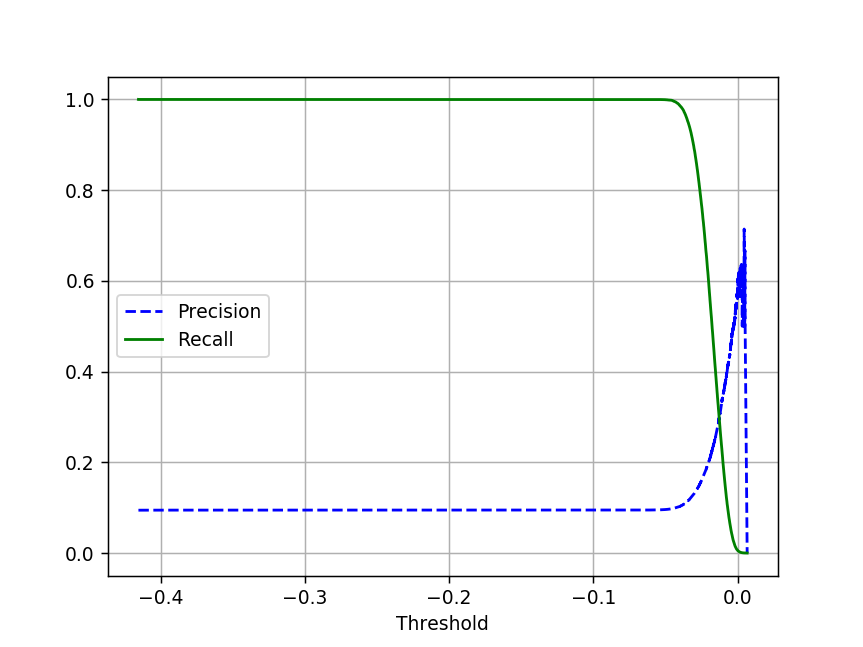

In [53]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(test_y, y_scores)

%matplotlib notebook

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend() 
    plt.xlabel("Threshold")        
    plt.grid(True)                               

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

<IPython.core.display.Javascript object>


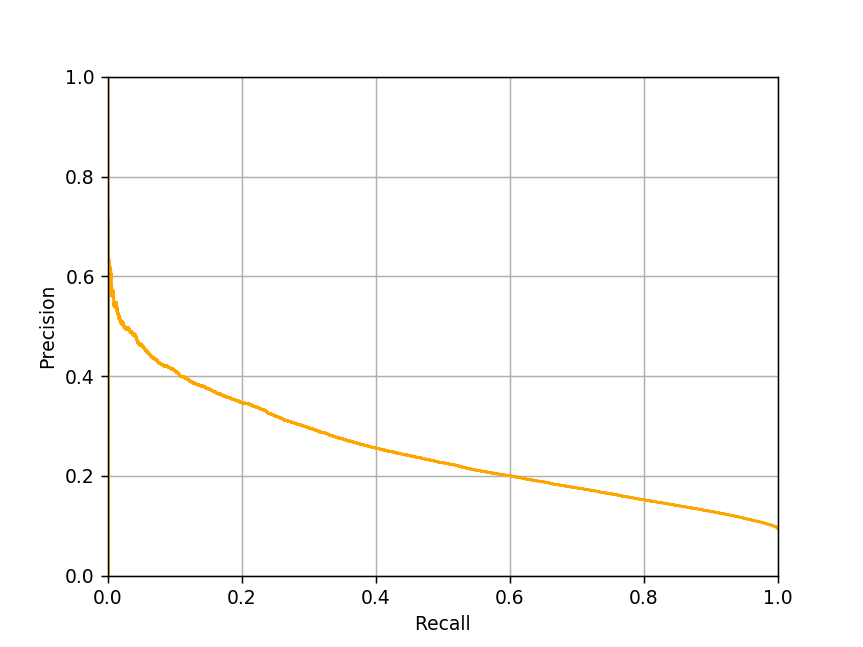

In [50]:
%matplotlib notebook

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, color='orange')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plot_precision_vs_recall(precisions, recalls)
plt.show()

#### Receiver Operating Characteristic Curve (ROC)

In [46]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# auc stands for 'area under curve', the closer this is to 1 the better 
# the model is at distinguishing between the background and signal

auc = roc_auc_score(test_y, y_scores)
print('AUC: %.2f' % auc)

AUC: 0.74


<IPython.core.display.Javascript object>


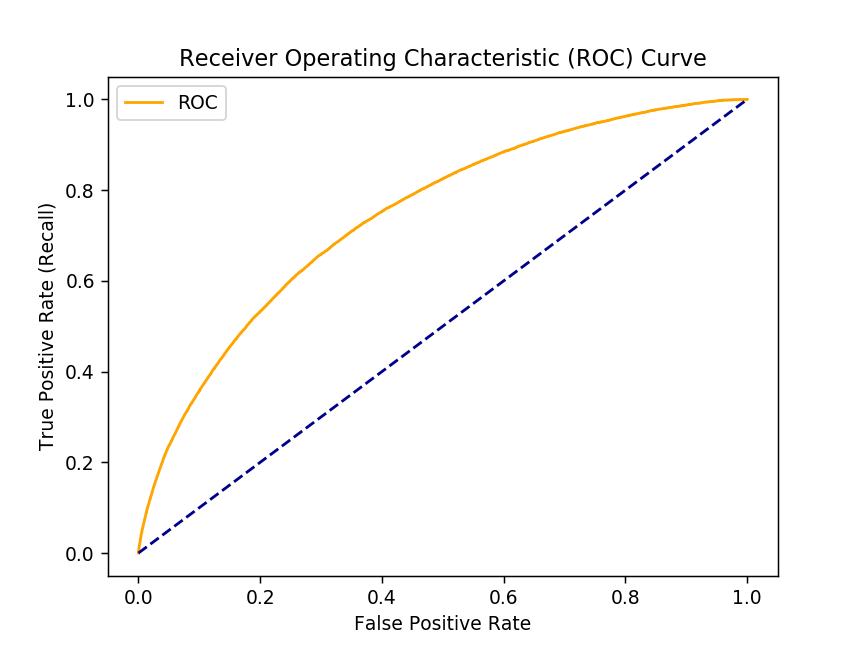

In [48]:
# Get the ROC curve
fpr, tpr, thresholds = roc_curve(test_y, y_scores)

%matplotlib notebook
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--') #axis
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Applying this to different tests

### Trying this for test_size = 0.4, n_estimators = 300, learning_rate = 2

In [73]:
train_bkg, test_bkg = train_test_split(background, test_size=0.4, random_state=2)
train_signal, test_signal = train_test_split(signal, test_size=0.4, random_state=2)

train_y = len(train_bkg) * [0] + len(train_signal) * [1]
test_y = len(test_bkg) * [0] + len(test_signal) * [1]

train_x = pd.concat([train_bkg, train_signal], ignore_index=True)
test_x = pd.concat([test_bkg, test_signal], ignore_index=True)

train_x.drop(["weight"], axis=1, inplace=True)
test_x.drop(["weight"], axis=1, inplace=True)


BDT_clf = AdaBoostClassifier(n_estimators=300, learning_rate = 2).fit(train_x, train_y)
train_score = BDT_clf.score(train_x, train_y)
test_score  = BDT_clf.score(test_x, test_y)

print("Decision Tree Classifier Score is:")
print("\tTrain Score = ", train_score)
print("\tTest Score  = {:5.4f}".format(test_score))
print("\tNumber of mis-classified test data = {:2.1f}".format((1-test_score)*len(test_x)))

Decision Tree Classifier Score is:
	Train Score =  0.6220560222188831
	Test Score  = 0.6223
	Number of mis-classified test data = 103900.0


In [74]:
from sklearn.metrics import precision_score, recall_score

predictions = BDT_clf.predict(test_x)
precision = precision_score(test_y, predictions)
print("The precision score is: %.3f" % precision)

recall = recall_score(test_y, predictions)
print("The recall score is: %.3f" % recall)

The precision score is: 0.150
The recall score is: 0.645


<IPython.core.display.Javascript object>


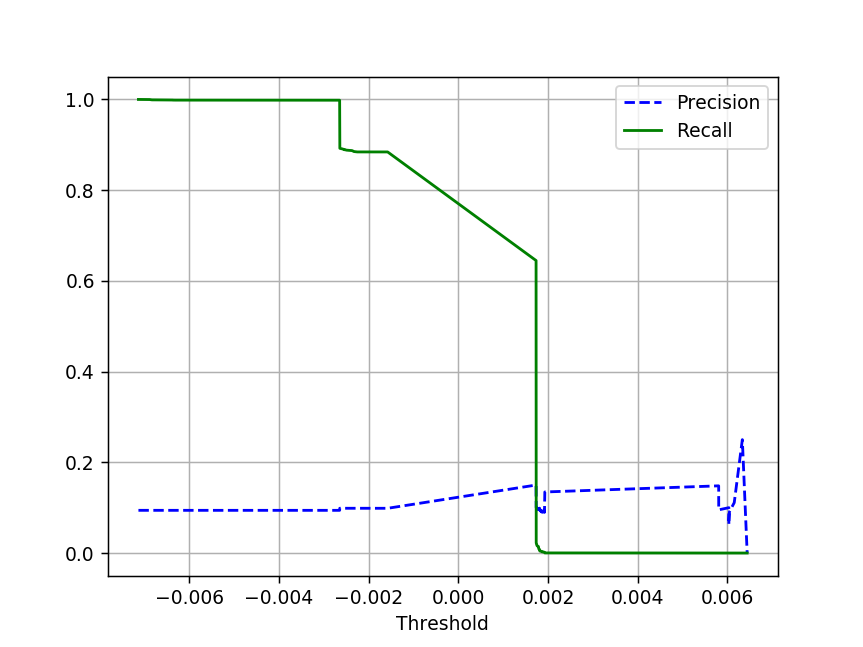

In [60]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

y_scores = BDT_clf.decision_function(test_x)
#print(y_scores)

precisions, recalls, thresholds = precision_recall_curve(test_y, y_scores)

%matplotlib notebook

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend() 
    plt.xlabel("Threshold")        
    plt.grid(True)                               

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

<IPython.core.display.Javascript object>


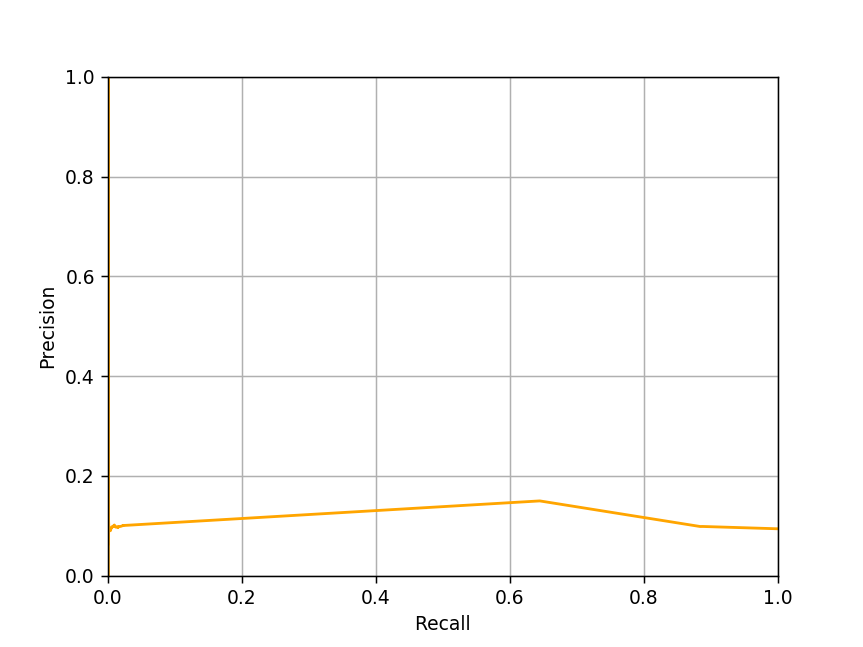

In [61]:
%matplotlib notebook

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, color='orange')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plot_precision_vs_recall(precisions, recalls)
plt.show()

In [62]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# auc stands for 'area under curve', the closer this is to 1 the better 
# the model is at distinguishing between the background and signal

auc = roc_auc_score(test_y, y_scores)
print('AUC: %.2f' % auc)

AUC: 0.62


<IPython.core.display.Javascript object>


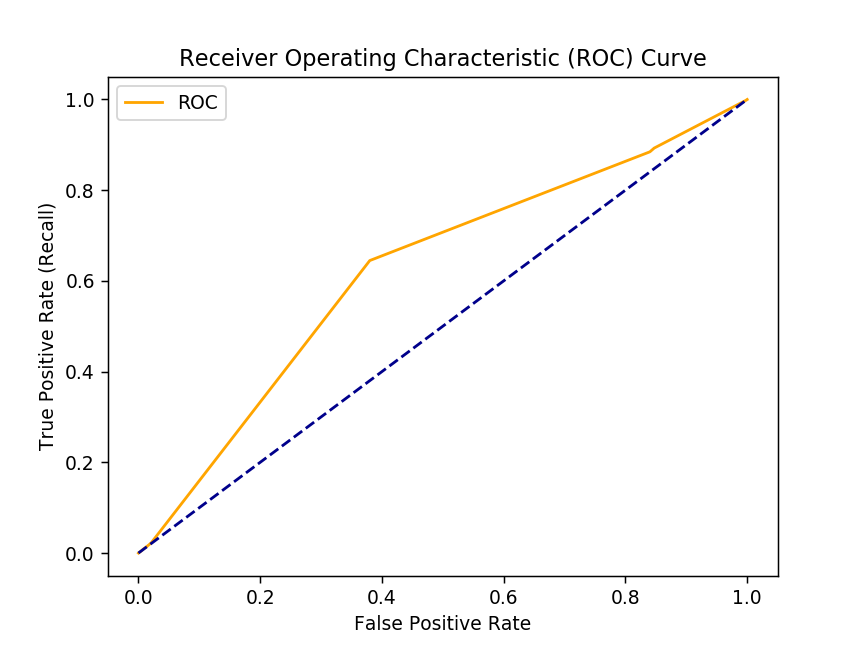

In [63]:
# Get the ROC curve
fpr, tpr, thresholds = roc_curve(test_y, y_scores)

%matplotlib notebook
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--') #axis
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### Trying this for max_depth = 3, test_size = 0.6, n_estimators = 300, learning rate = 2

In [75]:
train_bkg, test_bkg = train_test_split(background, test_size=0.6, random_state=2)
train_signal, test_signal = train_test_split(signal, test_size=0.6, random_state=2)

train_y = len(train_bkg) * [0] + len(train_signal) * [1]
test_y = len(test_bkg) * [0] + len(test_signal) * [1]

train_x = pd.concat([train_bkg, train_signal], ignore_index=True)
test_x = pd.concat([test_bkg, test_signal], ignore_index=True)

train_x.drop(["weight"], axis=1, inplace=True)
test_x.drop(["weight"], axis=1, inplace=True)

print("Data has been split into test and train samples")
print("\tN(train) = ", len(train_x))
print("\tN(test)  = ", len(test_x))

Data has been split into test and train samples
	N(train) =  275081
	N(test)  =  412623


In [76]:
from sklearn.metrics import precision_score, recall_score

predictions = BDT_clf.predict(test_x)
precision = precision_score(test_y, predictions)
print("The precision score is: %.3f" % precision)

recall = recall_score(test_y, predictions)
print("The recall score is: %.3f" % recall)

The precision score is: 0.151
The recall score is: 0.650


In [77]:
from sklearn.tree import DecisionTreeClassifier

print("\033[1mFit the decision tree\033[0m")
BDT_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), algorithm="SAMME", 
                             n_estimators=300, learning_rate=2).fit(train_x, train_y)

print("... now compute the decision tree score")
train_score = BDT_clf.score(train_x, train_y)
test_score  = BDT_clf.score(test_x, test_y)

print("\nDecision Tree Classifier Score is:")
print("\tTrain Score = ", train_score, " (This measure of performance is biased)")
print("\tTest Score  = {:5.4f}".format(test_score))
print("\tNumber of mis-classified test data = {:2.1f}".format((1-test_score)*len(test_x)))

Fit the decision tree
... now compute the decision tree score

Decision Tree Classifier Score is:
	Train Score =  0.10167187119430277  (This measure of performance is biased)
	Test Score  = 0.1018
	Number of mis-classified test data = 370638.0


<IPython.core.display.Javascript object>


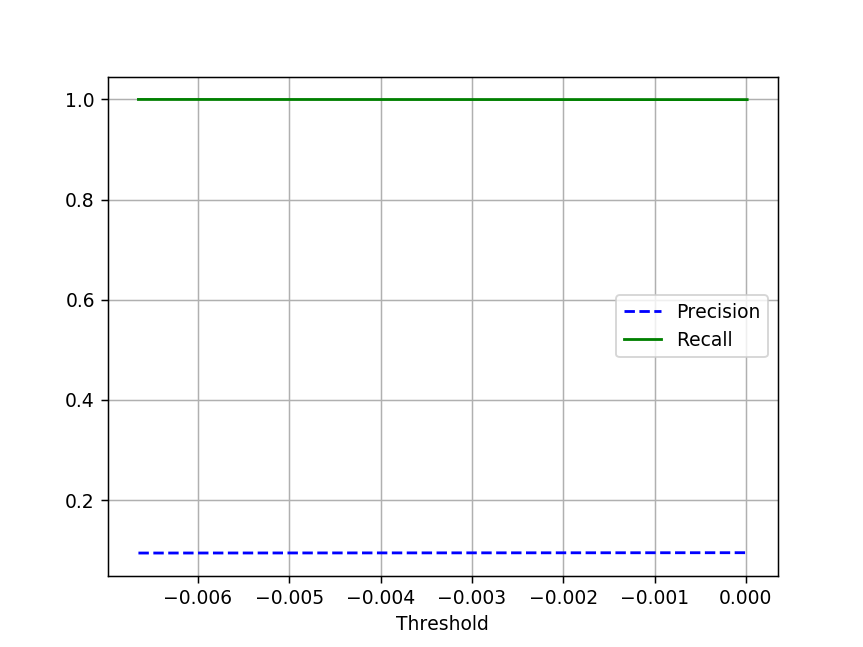

In [81]:
y_scores = BDT_clf.decision_function(test_x)
#print(y_scores)

precisions, recalls, thresholds = precision_recall_curve(test_y, y_scores)

%matplotlib notebook

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend() 
    plt.xlabel("Threshold")        
    plt.grid(True)                               

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

<IPython.core.display.Javascript object>


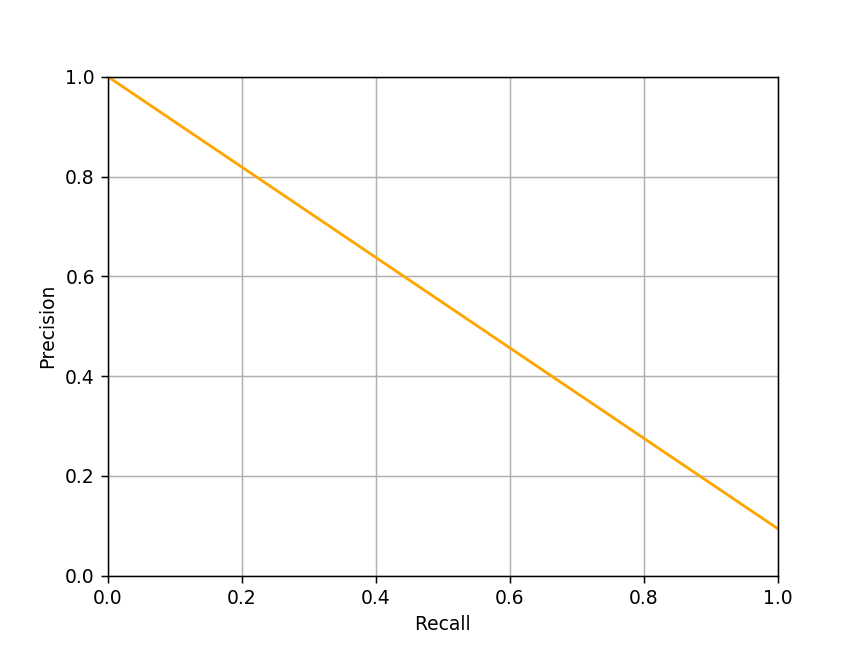

In [82]:
%matplotlib notebook

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, color='orange')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plot_precision_vs_recall(precisions, recalls)
plt.show()

AUC: 0.50


<IPython.core.display.Javascript object>


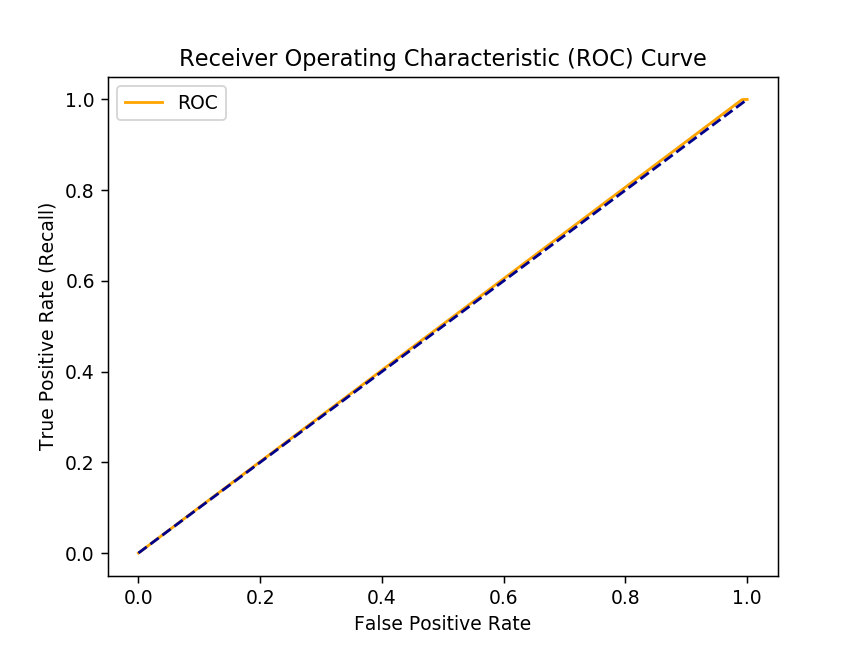

In [80]:
auc = roc_auc_score(test_y, y_scores)
print('AUC: %.2f' % auc)

# Get the ROC curve
fpr, tpr, thresholds = roc_curve(test_y, y_scores)

%matplotlib notebook
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--') #axis
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

The model has no discrimination capabilities at all in this case

### max_depth = 2, test_size = 0.4, n_estimators = 300, learning rate = 1

In [83]:
train_bkg, test_bkg = train_test_split(background, test_size=0.4, random_state=2)
train_signal, test_signal = train_test_split(signal, test_size=0.4, random_state=2)

train_y = len(train_bkg) * [0] + len(train_signal) * [1]
test_y = len(test_bkg) * [0] + len(test_signal) * [1]

train_x = pd.concat([train_bkg, train_signal], ignore_index=True)
test_x = pd.concat([test_bkg, test_signal], ignore_index=True)

train_x.drop(["weight"], axis=1, inplace=True)
test_x.drop(["weight"], axis=1, inplace=True)

print("Data has been split into test and train samples")
print("\tN(train) = ", len(train_x))
print("\tN(test)  = ", len(test_x))

Data has been split into test and train samples
	N(train) =  412622
	N(test)  =  275082


In [84]:
predictions = BDT_clf.predict(test_x)
precision = precision_score(test_y, predictions)
print("The precision score is: %.3f" % precision)

recall = recall_score(test_y, predictions)
print("The recall score is: %.3f" % recall)

The precision score is: 0.095
The recall score is: 1.000


In [86]:
print("\033[1mFit the decision tree\033[0m")
BDT_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), algorithm="SAMME", 
                             n_estimators=300).fit(train_x, train_y)

print("... now compute the decision tree score")
train_score = BDT_clf.score(train_x, train_y)
test_score  = BDT_clf.score(test_x, test_y)

print("\nDecision Tree Classifier Score is:")
print("\tTrain Score = ", train_score, " (This measure of performance is biased)")
print("\tTest Score  = {:5.4f}".format(test_score))
print("\tNumber of mis-classified test data = {:2.1f}".format((1-test_score)*len(test_x)))

Fit the decision tree
... now compute the decision tree score

Decision Tree Classifier Score is:
	Train Score =  0.9061683574797272  (This measure of performance is biased)
	Test Score  = 0.9063
	Number of mis-classified test data = 25769.0


<IPython.core.display.Javascript object>


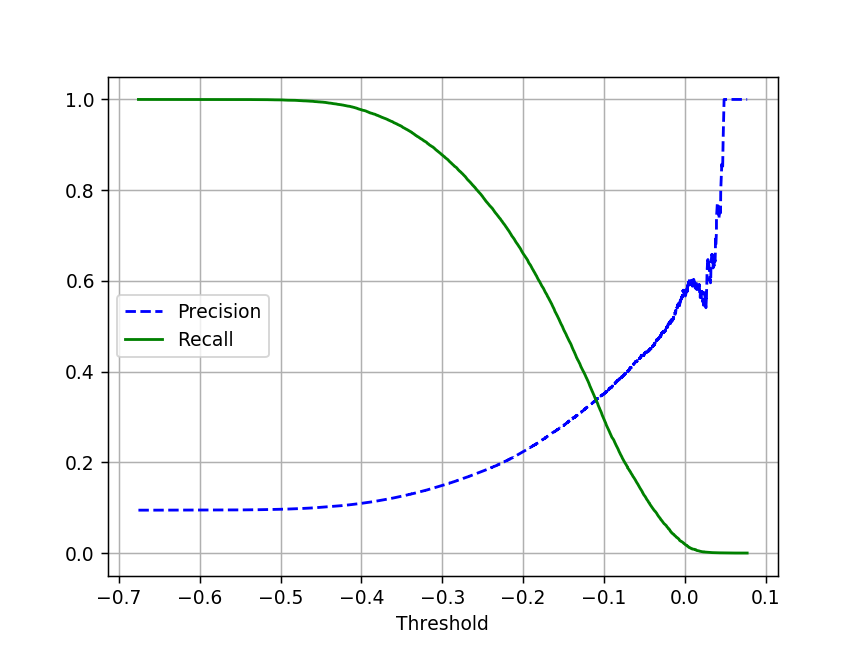

In [87]:
y_scores = BDT_clf.decision_function(test_x)
#print(y_scores)

precisions, recalls, thresholds = precision_recall_curve(test_y, y_scores)

%matplotlib notebook

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend() 
    plt.xlabel("Threshold")        
    plt.grid(True)                               

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

<IPython.core.display.Javascript object>


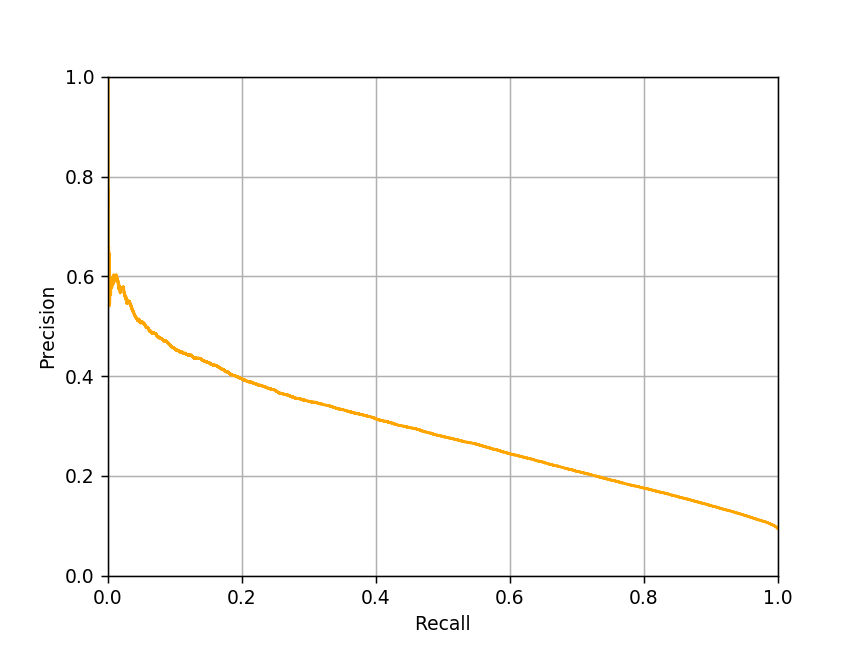

In [88]:
%matplotlib notebook

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, color='orange')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plot_precision_vs_recall(precisions, recalls)
plt.show()

AUC: 0.78


<IPython.core.display.Javascript object>


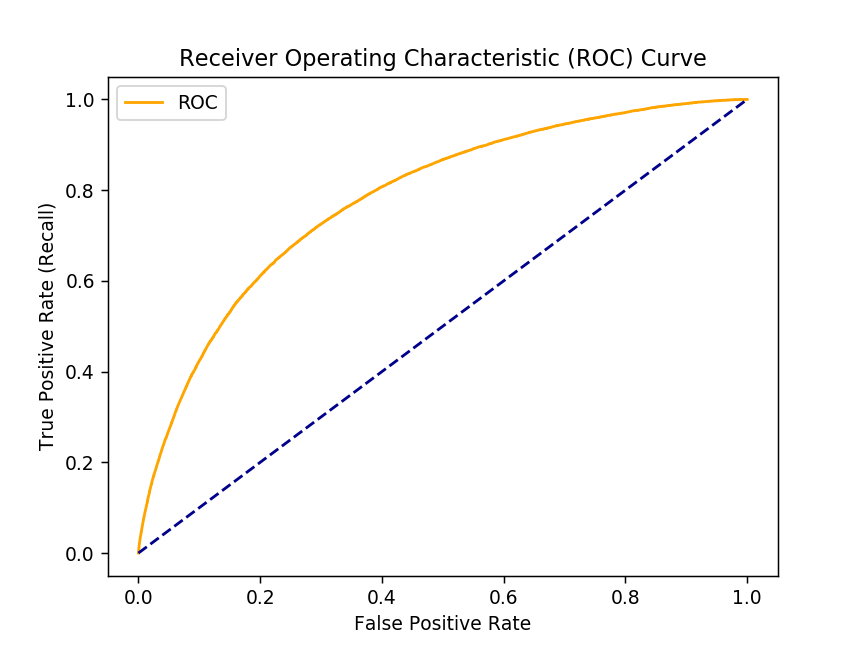

In [89]:
auc = roc_auc_score(test_y, y_scores)
print('AUC: %.2f' % auc)

# Get the ROC curve
fpr, tpr, thresholds = roc_curve(test_y, y_scores)

%matplotlib notebook
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--') #axis
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### max_depth = 2, test_size = 0.4, n_estimators = 500, learning rate = 1

In [90]:
train_bkg, test_bkg = train_test_split(background, test_size=0.4, random_state=2)
train_signal, test_signal = train_test_split(signal, test_size=0.4, random_state=2)

train_y = len(train_bkg) * [0] + len(train_signal) * [1]
test_y = len(test_bkg) * [0] + len(test_signal) * [1]

train_x = pd.concat([train_bkg, train_signal], ignore_index=True)
test_x = pd.concat([test_bkg, test_signal], ignore_index=True)

train_x.drop(["weight"], axis=1, inplace=True)
test_x.drop(["weight"], axis=1, inplace=True)

print("Data has been split into test and train samples")
print("\tN(train) = ", len(train_x))
print("\tN(test)  = ", len(test_x))

Data has been split into test and train samples
	N(train) =  412622
	N(test)  =  275082


In [91]:
predictions = BDT_clf.predict(test_x)
precision = precision_score(test_y, predictions)
print("The precision score is: %.3f" % precision)

recall = recall_score(test_y, predictions)
print("The recall score is: %.3f" % recall)

The precision score is: 0.575
The recall score is: 0.020


In [92]:
print("\033[1mFit the decision tree\033[0m")
BDT_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), algorithm="SAMME", 
                             n_estimators=500).fit(train_x, train_y)

print("... now compute the decision tree score")
train_score = BDT_clf.score(train_x, train_y)
test_score  = BDT_clf.score(test_x, test_y)

print("\nDecision Tree Classifier Score is:")
print("\tTrain Score = ", train_score, " (This measure of performance is biased)")
print("\tTest Score  = {:5.4f}".format(test_score))
print("\tNumber of mis-classified test data = {:2.1f}".format((1-test_score)*len(test_x)))

Fit the decision tree
... now compute the decision tree score

Decision Tree Classifier Score is:
	Train Score =  0.9061489692745418  (This measure of performance is biased)
	Test Score  = 0.9063
	Number of mis-classified test data = 25773.0


<IPython.core.display.Javascript object>


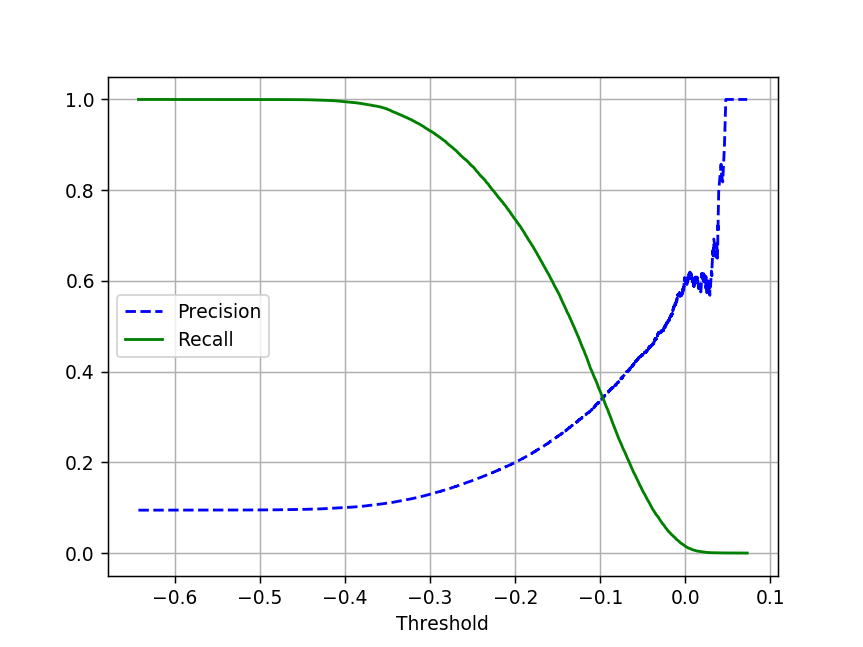

In [93]:
y_scores = BDT_clf.decision_function(test_x)
#print(y_scores)

precisions, recalls, thresholds = precision_recall_curve(test_y, y_scores)

%matplotlib notebook

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend() 
    plt.xlabel("Threshold")        
    plt.grid(True)                               

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

<IPython.core.display.Javascript object>


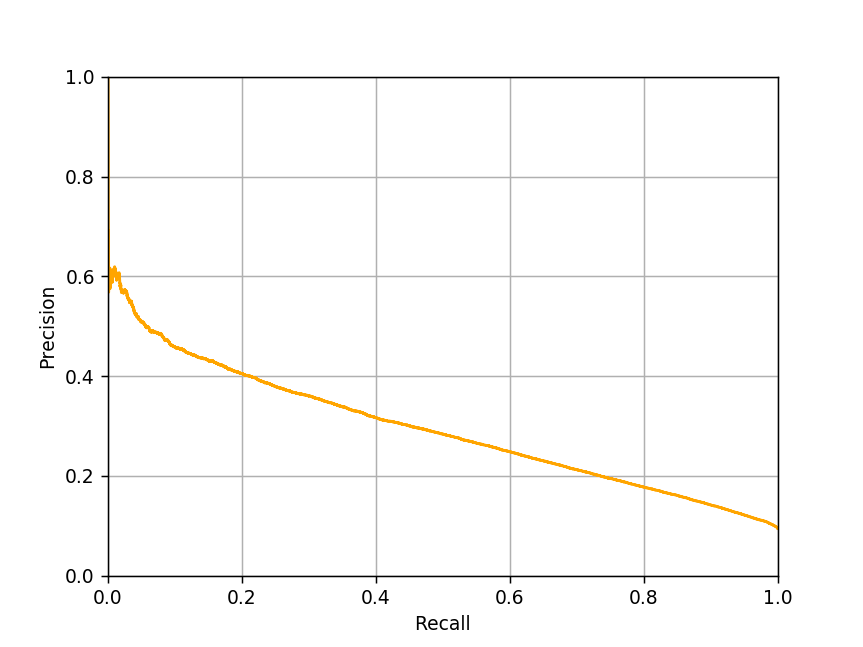

In [94]:
%matplotlib notebook

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, color='orange')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plot_precision_vs_recall(precisions, recalls)
plt.show()

AUC: 0.78


<IPython.core.display.Javascript object>


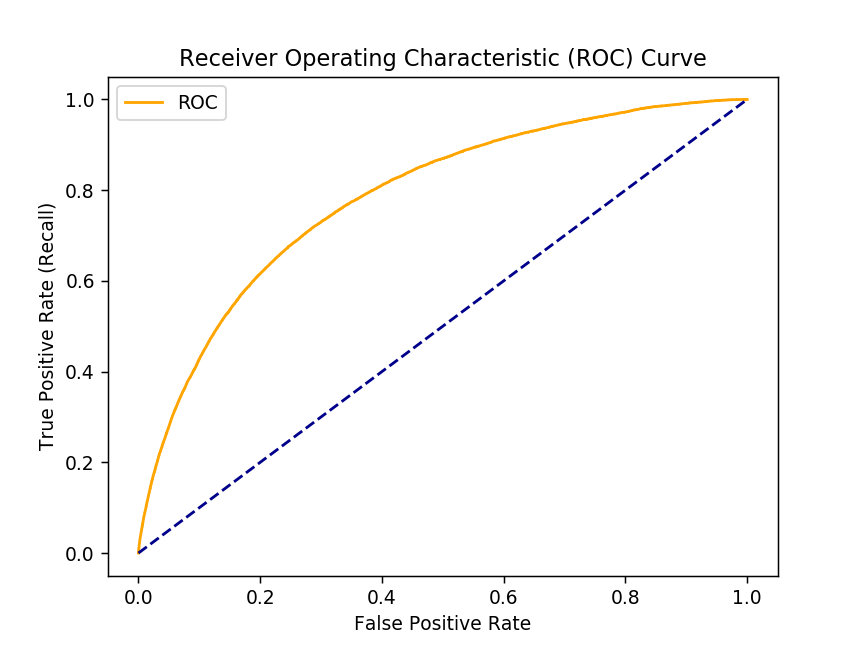

In [95]:
auc = roc_auc_score(test_y, y_scores)
print('AUC: %.2f' % auc)

# Get the ROC curve
fpr, tpr, thresholds = roc_curve(test_y, y_scores)

%matplotlib notebook
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--') #axis
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()